---
**Method of lines and explicit euler**

Week 20 of EMAT30008

https://engmaths.github.io/emat30008/pdes/explicit/

(See scicomp/odefunctions.py for associated functions)

Author: Ben Winstanley, yy23737@bristol.ac.uk

---

In [1]:
import numpy as np
from scipy.optimize import root
import matplotlib.pyplot as plt
from typing import Literal
from scicomp.odefunctions import *

/Applications/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


We solve the diffusion PDE

$\frac{dx}{dt} = D \frac{d^2 u}{d x^2} + q(x,t,u:\mu) $

over domain $a \leq x \leq b$, $D > 0$

------
Q1

Use explicit euler method to solve the equation when $D=1$ and $q=0$. 

Dirichlet boundary $u(a,t)=u(b,t)=0$

Initial condition: $u(x,0) = sin(\frac{\pi (x-a)}{b-a})$

We split into N+1 grid points $x_i$ and each $u_i = u(x=x_i, t)$ becomes a state variable of its own. 

We approximate the RHS space derivative using the finite difference method with relevant boundary conditions. 

We then just solve the equation, passing the RHS into our solve_to function, since we have an equation of the form 
$\frac{du}{dt} = F(x,t)$

------------
Before we can do this we have to split up `finite_diff_bvp_solver` from week 19 into 2 parts

In [2]:
# We begin by splitting our finite_diff_bvp_solver into that and a construct_A_and_b function

def bvp_construct_A_and_b(num_grid_points: int,
                          grid_bounds: list[float],
                          left_boundary_vals: list[float],
                          right_boundary_vals: list[float],
                          left_boundary_type: Literal['Dirichlet', 'Neumann', 'Robin'] = 'Dirichlet', 
                          right_boundary_type: Literal['Dirichlet', 'Neumann', 'Robin'] = 'Dirichlet',
                          ):
    '''
    Prepares the matrix A_matrix and vector b_vector for use in finite difference solving for a BVP diffusion problem.
    See finite_diff_bvp_solver function.
    
    Problems are of form:
    D (d^2u/dx2) + q(x,u:mu) = 0
    between a<=x<=b, where D is the diffusivity (scalar), and q is any source function.

    Boundary conditions (at end x=a WLOG):
    - Dirichlet: u(a) = alpha
    - Neumann: du/dx{a} = alpha
    - Robin: du/dx{a} = alpha + beta*u(a)
    where alpha is specified.

    -----
    Parameters
    -----
    num_grid_points : int
        The number of spatial x grid points used in the numerical approximation.
    grid_bounds : [a,b] where a<b are floats
        The bounds a<=x<=b of the problem.
    left_boundary_vals : [alpha, beta] where alpha,beta are floats
        The constant values used to describe the left boundary condition. Beta optional, used for Robin boundary
    right_boundary_vals : [alpha, beta] where alpha,beta are floats
        The constant values used to describe the left boundary condition. Beta optional, used for Robin boundary
    left_boundary_type : 'Dirichlet', 'Neumann', or 'Robin', default 'Dirichlet'
        The string used to specify the type of boundary condition on the left.
    right_boundary_type : 'Dirichlet', 'Neumann', or 'Robin', default 'Dirichlet'
        The string used to specify the type of boundary condition on the right.

    -----
    Returns
    -----
    A_matrix : 2-D tridiagonal matrix array
        The corresponding matrix used to specify the 2nd order diffusion term and boundary values
    b_matrix : 1-D vector array
        The corresponding vector used to specify the 2nd order diffusion term and boundary values
    left_dirichlet_val : float or None
        Value of the left dirichlet boundary u(a) = alpha, None if not a dirichlet boundary
    right_dirichlet_val : float or None
        Value of the right dirichlet boundary u(b) = beta, None if not a dirichlet boundary
    
    -----
    Example
    -----
    >>> A_matrix, b_vec, left_dirichlet_val, right_dirichlet_val = bvp_construct_A_and_b(5,[0,5],[1.5],[3],'Dirichlet','Neumann')
    >>> print(A_matrix)
    [[-2.  1.  0.  0.  0.]
    [ 1. -2.  1.  0.  0.]
    [ 0.  1. -2.  1.  0.]
    [ 0.  0.  1. -2.  1.]
    [ 0.  0.  0.  2. -2.]]
    >>> print(b_vec)
    [1.5 0.  0.  0.  6. ]
    >>> print(left_dirichlet_val)
    1.5
    >>> print(right_dirichlet_val)
    None

    -----
    Notes
    -----
    We use a centred finite difference scheme to approximate the second derivative, and
    we use ghost points for the derivative boundary conditions (Neumann, Robin).
    We construct tridiagonal matrices A_matrix and associated vectors b_vec,
    converting the problem into a linear algebra problem to be solved by numpy's linalg package
    In the case of a nonlinear dependence q(u) we employ root finding instead to find 
    a solution where linear algebra cannot be used.

    -----
    Raises
    -----
    Exception
        If the number of grid points are 3 or less (impractical).
    Exception
        If a,b in the grid bounds are such that b<=a
    Exception
        If the left or right boundary condition is Robin and the 
         associated values isn't length 2.

    -----
    See also
    -----
    .   
    '''
    if num_grid_points < 4:
        raise Exception("Please use more grid points.")
    if grid_bounds[0] >= grid_bounds[1]:
        raise Exception("Grid bounds must be in format [a,b] where a < b.")
    if left_boundary_type == 'Robin':
        if len(left_boundary_vals) != 2:
            raise Exception("Please enter 2 values for left_boundary_vals when using Robin boundary condition.")
    if right_boundary_type == 'Robin':
        if len(right_boundary_vals) != 2:
            raise Exception("Please enter 2 values for right_boundary_vals when using Robin boundary condition.")

    N = num_grid_points
    a, b = grid_bounds

    # Establish delta_x
    delta_x = (b-a)/(N-1)

    # Initiate holders for dirichlet boundary conditions
    left_dirichlet_val, right_dirichlet_val = None, None

    # Calculate number of interior grid points based on boundary conditions
    N_interior = N-2
    if left_boundary_type != 'Dirichlet':
        N_interior += 1  # Include additional ghost point (on left)
    else:
        left_dirichlet_val = left_boundary_vals[0]
    if right_boundary_type != 'Dirichlet':
        N_interior += 1  # Include additional ghost point (on right)
    else:
        right_dirichlet_val = right_boundary_vals[0]
    
    # Initialise b_vec and A_matrix
    b_vec = np.zeros([N_interior])
    A_matrix = -2*np.eye(N_interior,k=0) + np.eye(N_interior,k=1) + np.eye(N_interior,k=-1)

    # Treat left boundary
    if left_boundary_type == 'Dirichlet':
        b_vec[0] = left_boundary_vals[0]
    elif left_boundary_type == 'Neumann':
        b_vec[0] = -left_boundary_vals[0]*2*delta_x
        A_matrix[0,1] = 2
    elif left_boundary_type == 'Robin':
        b_vec[0] = -left_boundary_vals[0]*2*delta_x
        A_matrix[0,1] = 2
        A_matrix[0,0] = -2*(1+delta_x*left_boundary_vals[1])

    # Treat right boundary
    if right_boundary_type == 'Dirichlet':
        b_vec[-1] = right_boundary_vals[0]
    elif right_boundary_type == 'Neumann':
        b_vec[-1] = right_boundary_vals[0]*2*delta_x
        A_matrix[-1,-2] = 2
    elif right_boundary_type == 'Robin':
        b_vec[-1] = right_boundary_vals[0]*2*delta_x
        A_matrix[-1,-2] = 2
        A_matrix[-1,-1] = -2*(1+delta_x*right_boundary_vals[1])

    return A_matrix, b_vec, left_dirichlet_val, right_dirichlet_val

In [3]:
A_matrix, b_vec, left_dirichlet_val, right_dirichlet_val = bvp_construct_A_and_b(5,[0,5],[1.5],[3],'Dirichlet','Neumann')
print(A_matrix)
print(b_vec)
print(left_dirichlet_val)
print(right_dirichlet_val)

[[-2.  1.  0.  0.]
 [ 1. -2.  1.  0.]
 [ 0.  1. -2.  1.]
 [ 0.  0.  2. -2.]]
[1.5 0.  0.  7.5]
1.5
None


In [4]:
def finite_diff_bvp_solver(num_grid_points: int,
                           diffusivity: float,
                           grid_bounds: list[float],
                           A_matrix: np.ndarray,
                           b_vec: np.ndarray,
                           left_dirichlet_val,
                           right_dirichlet_val,
                           q_func = None,
                           q_nonlinear: bool = False,
                           q_param: float = None,
                           guess_function = None
                           ):
    '''
    Numerically solves a diffusion equation in 1D with given boundary conditions and source function, using the finite difference method.

    Solves problems of form:
    D (d^2u/dx2) + q(x,u:mu) = 0
    between a<=x<=b, where D is the diffusivity (scalar), and q is any source function.

    Boundary conditions (at end x=a WLOG):
    - Dirichlet: u(a) = alpha
    - Neumann: du/dx{a} = alpha
    - Robin: du/dx{a} = alpha + beta*u(a)
    where alpha is specified.

    Boundary conditions are specified via the inputs A_matrix, b_vec and left_dirichlet_val, right_dirichlet_val.
    These are obtained from the bvp_construct_A_and_b function.

    -----
    Parameters
    -----
    num_grid_points : int
        The number of spatial x grid points used in the numerical approximation.
    diffusivity : float
        The diffusivity constant of the system. Higher means more 'flattening'.
    grid_bounds : [a,b] where a<b are floats
        The bounds a<=x<=b of the problem.
    A_matrix : 2-D tridiagonal matrix array
        The corresponding matrix used to specify the 2nd order diffusion term and boundary values
    b_matrix : 1-D vector array
        The corresponding vector used to specify the 2nd order diffusion term and boundary values
    left_dirichlet_val : float or None
        Value of the left dirichlet boundary u(a) = alpha, None if not a dirichlet boundary
    right_dirichlet_val : float or None
        Value of the right dirichlet boundary u(b) = beta, None if not a dirichlet boundary
    q_func : function, default None
        The scalar source term function q(x,u:mu).
    q_nonlinear : bool, default False
        True if the function q has dependence on u
    q_param : float, default None
        The parameter value mu passed to source function q
    guess_function : function, default None
        A function that guesses the solution, used when source term q is nonlinear

    -----
    Returns
    -----
    u_interior : 1-D array, length num_grid_points
        The solution to the differential equation.
    x_vals : 1-D array, length num_grid_points
        The corresponding x grid points
    
    -----
    Example
    -----
    >>> import numpy as np
    >>> num_grid_points = 5
    >>> grid_bounds = [0,5]
    >>> diffusivity = 2
    >>> A_matrix, b_vec, left_dirichlet_val, right_dirichlet_val = bvp_construct_A_and_b(num_grid_points, grid_bounds,[1.5],[3],'Dirichlet','Neumann')
    >>> def source_func(x,u,mu):
            return np.sin(x)
    >>> solution, xvals = finite_diff_bvp_solver(num_grid_points, diffusivity,grid_bounds, A_matrix, b_vec, left_dirichlet_val, right_dirichlet_val, source_func)
    >>> print(solution)
    [ 1.5         4.82781189  7.73488829 10.18731598 12.56918367 15.3294526 ]
    >>> print(xvals)
    [0. 1. 2. 3. 4. 5.]

    -----
    Notes
    -----
    We use a centred finite difference scheme to approximate the second derivative, and
    we use ghost points for the derivative boundary conditions (Neumann, Robin).
    We construct tridiagonal matrices A_matrix and associated vectors b_vec,
    converting the problem into a linear algebra problem to be solved by numpy's linalg package
    In the case of a nonlinear dependence q(u) we employ root finding instead to find 
    a solution where linear algebra cannot be used.

    -----
    Raises
    -----
    Exception
        If the number of grid points are 3 or less (impractical).
    Exception
        If a,b in the grid bounds are such that b<=a
    Exception
        If the left or right boundary condition is Robin and the 
         associated values isn't length 2.

    -----
    See also
    -----
    bvp_construct_A_and_b
        Constructs A_matrix, b_vec, left_dirichlet_val and right_dirichlet_val used for   
    '''
    # Error Messages
    if grid_bounds[0] >= grid_bounds[1]:
        raise Exception("Grid bounds must be in format [a,b] where a < b.")
    
    # Unpack and rename inputs
    D = diffusivity
    N = num_grid_points
    a, b = grid_bounds

    # Establish x grid
    x_vals = np.linspace(a,b,N)
    delta_x = (b-a)/(N-1)

    # Extract interior values
    x_vals_interior = x_vals
    if left_dirichlet_val != None:
        x_vals_interior = x_vals_interior[1:]
    if right_dirichlet_val != None:
        x_vals_interior = x_vals_interior[:-1]
        
    # If no source term q then call linalg to solve
    if q_func == None:
        u_interior = np.linalg.solve(A_matrix, -b_vec)

    # If there is a source term q, then split by linear or nonlinear
    elif not q_nonlinear:
        # q(x,u:mu) = q(x:mu) so calculate fixed values
        q_vals_interior = q_func(x=x_vals_interior, u=None, mu = q_param)

        # Solve with linalg solve
        rhs_vec = -b_vec - ((delta_x**2)/D)*q_vals_interior
        u_interior = np.linalg.solve(A_matrix, rhs_vec)

    elif q_nonlinear:
        # Define objective function to minimise
        def objective(u):
            q_vals_interior = q_func(x=x_vals_interior, u=u, mu= q_param)
            F = np.matmul(A_matrix, u) + b_vec + ((delta_x**2)/D)*q_vals_interior
            return F
        
        # Establish initial guess solution via a function
        # If guess solution function isn't supplied then define one
        if guess_function == None:
            # If both Dirichlet bounds given:
            if (left_dirichlet_val != None) and (right_dirichlet_val != None):
                # Establish function connecting both points
                def guess_function(x):
                    return left_dirichlet_val + ((right_dirichlet_val-left_dirichlet_val)/(b-a))*(x-a)
                
            elif left_dirichlet_val != None:
                # Establish function with constant left boundary value
                def guess_function(x):
                    return left_dirichlet_val*np.ones([len(x)])
                
            elif right_dirichlet_val != None:
                # Establish function with constant right boundary value
                def guess_function(x):
                    return right_dirichlet_val*np.ones([len(x)])
                
            else:
                # Establish function f(x) = 1
                def guess_function(x):
                    return np.ones([len(x)])
        
        # Calculate guess solution
        u_guess = guess_function(x_vals_interior)

        # Solve via scipy root with initial guess solution 
        solution = root(objective, u_guess)
        u_interior = solution.x

    # Add prescribed boundary points if Dirichlet, u_interior becomes full solution
    if left_dirichlet_val != None:
        u_interior = np.concatenate(([left_dirichlet_val], u_interior))
    if right_dirichlet_val != None:
        u_interior = np.concatenate((u_interior, [left_dirichlet_val]))
    
    return u_interior, x_vals

In [5]:
import numpy as np
num_grid_points = 5
grid_bounds = [0,5]
diffusivity = 2
A_matrix, b_vec, left_dirichlet_val, right_dirichlet_val = bvp_construct_A_and_b(num_grid_points, grid_bounds,[1.5],[3],'Dirichlet','Neumann')
def source_func(x,u,mu):
    return np.sin(x)
solution, xvals = finite_diff_bvp_solver(num_grid_points, diffusivity,grid_bounds, A_matrix, b_vec, left_dirichlet_val, right_dirichlet_val, source_func)
print(solution)
print(xvals)

[ 1.5         5.63783852  9.03428281 11.96317073 15.33859094]
[0.   1.25 2.5  3.75 5.  ]


-----------
Explicit Euler stepping

We use the method of lines to approximate the main PDE into an ODE via a finite difference approximation of the spatial derivatives.

Our equation becomes

$\frac{d\vec{u}}{dt} = \frac{D}{(\Delta x)^2}(A \vec{u} + b) + q$

We can then just pass this RHS into our solve_to function using an Euler or Runge-Kutta step. Here our state variables are $\vec{u} = (u_0, u_1, ..., u_N)$. Note here these are only interior points 

In [16]:
def diffusion_pde_solver(num_grid_points: int,
                          grid_bounds: list[float],
                          diffusivity: float,
                          init_func,
                          t_init: float,
                          t_final: float,
                          deltat_max: float,
                          left_boundary_vals: list[float],
                          right_boundary_vals: list[float],
                          left_boundary_type: Literal['Dirichlet', 'Neumann', 'Robin'] = 'Dirichlet', 
                          right_boundary_type: Literal['Dirichlet', 'Neumann', 'Robin'] = 'Dirichlet',
                          q_func = None,
                          method: Literal['Explicit Euler'] = 'Explicit Euler'):
    '''  
    Solves 1-D diffusion PDEs with the method of lines, using different timestepping methods.

    -----
    Parameters
    -----
    num_grid_points : int
        The number of spatial x grid points used in the numerical approximation.
    grid_bounds : [a,b] where a<b are floats
        The bounds a<=x<=b of the problem.
    diffusivity : float
        The diffusivity constant of the system. Higher means more 'flattening'.
    init_func : function
        The initial spatial condition function u(x,0)
    t_init, t_final : floats
        Initial and final times.
    deltat_max : float
        Step size used in numerical timestepping, some final steps may be smaller than this.
    left_boundary_vals : [alpha, beta] where alpha,beta are floats
        The constant values used to describe the left boundary condition. Beta optional, used for Robin boundary
    right_boundary_vals : [alpha, beta] where alpha,beta are floats
        The constant values used to describe the left boundary condition. Beta optional, used for Robin boundary
    left_boundary_type : 'Dirichlet', 'Neumann', or 'Robin', default 'Dirichlet'
        The string used to specify the type of boundary condition on the left.
    right_boundary_type : 'Dirichlet', 'Neumann', or 'Robin', default 'Dirichlet'
        The string used to specify the type of boundary condition on the right.
    q_func : function
        The source function used in the PDE. Has to be of the form q=q(x)
    method : 'Explicit Euler'
        The type of timestepping method used to simulate the PDE
    
    ------
    Returns
    ------
    2-D Numpy array
        Full timeseries solution of PDE from t_init to t_final.
        Columns `[t, u1(t), u2(t), ... ,un(t)]`, with each row containing the time value after a timestep
        and the values of each state variable in `u=[u1, u2, ... ,un]`.

    -----
    Example
    -----
    >>> import numpy as np
    >>> store, xvals  = diffusion_pde_solver(5, [0,5], 1, np.sin ,0,10,0.1,[2],[3])
    >>> print(xvals)
    [0.   1.25 2.5  3.75 5.  ]
    >>> print(store)
    [[ 0.          1.          0.94898462  0.59847214 -0.57156132  1.        ]
    [ 0.1         1.          0.98973782  0.55942378 -0.28804692  1.        ]
    [ 0.2         1.          1.02397787  0.54321024 -0.04021254  1.        ]
    [ 0.3         1.          1.05369875  0.54479128  0.1774401   1.      
    ....
    [ 9.7         1.          2.20185124  2.43190158  2.70184305  1.        ]
    [ 9.8         1.          2.20362259  2.43440734  2.70361538  1.        ]
    [ 9.9         1.          2.20532881  2.43682091  2.70532247  1.        ]
    [10.          1.          2.20697228  2.43914566  2.7069667   1.        ]]

    -----
    See also
    -----
    bvp_construct_A_and_b
        Used inside this function to construct the matrix A and vector b.
    '''
    A_matrix, b_vec, left_dirichlet_val, right_dirichlet_val = bvp_construct_A_and_b(num_grid_points,
                                                                                     grid_bounds,
                                                                                     left_boundary_vals,
                                                                                     right_boundary_vals,
                                                                                     left_boundary_type,
                                                                                     right_boundary_type)
    
    # Unpack and rename inputs
    D = diffusivity
    N = num_grid_points
    a, b = grid_bounds

    # Establish x grid
    x_vals = np.linspace(a,b,N)
    delta_x = (b-a)/(N-1)

    # Extract interior values
    x_vals_interior = x_vals
    if left_dirichlet_val != None:
        x_vals_interior = x_vals_interior[1:]
    if right_dirichlet_val != None:
        x_vals_interior = x_vals_interior[:-1]

    # Determine initial conditions
    init_dist = init_func(x_vals_interior)
    
    # Define a rhs function depending on q
    if q_func == None:
        def rhs_func(params,x,t):
            return (D/(delta_x**2))*(np.matmul(A_matrix,x)+b_vec)

    else:
        def rhs_func(params,x,t):
            return (D/(delta_x**2))*(np.matmul(A_matrix,x)+b_vec)+q_func(x)
    
    if method == 'Explicit Euler':
        # Timestep via explicit Euler method:
        store = solve_to(rhs_func,None,init_dist,t_init, t_final, deltat_max)

    # Pack the remaining dirichlet boundaries on to the ends
    if left_dirichlet_val != None:
        n_timesteps, _ = np.shape(store)
        left_vals = np.ones([n_timesteps,1])
        store = np.concatenate((np.array([store[:,0]]).T,left_vals, store[:,1:]), axis=1)
    if right_dirichlet_val != None:
        n_timesteps, _ = np.shape(store)
        right_vals = np.ones([n_timesteps,1])
        store = np.concatenate((store,right_vals), axis=1)

    return store, x_vals

In [18]:
# Testing this function
store, xvals  = diffusion_pde_solver(num_grid_points, grid_bounds, 1, np.sin,0,10,0.1,
                              [2],[3])

print(store)

[[ 0.          1.          0.94898462  0.59847214 -0.57156132  1.        ]
 [ 0.1         1.          0.98973782  0.55942378 -0.28804692  1.        ]
 [ 0.2         1.          1.02397787  0.54321024 -0.04021254  1.        ]
 [ 0.3         1.          1.05369875  0.54479128  0.1774401   1.        ]
 [ 0.4         1.          1.0803842   0.5601365   0.36947799  1.        ]
 [ 0.5         1.          1.10512334  0.58602638  0.53970307  1.        ]
 [ 0.6         1.          1.1287017   0.61989236  0.69128779  1.        ]
 [ 0.7         1.          1.15167279  0.65968843  0.82688572  1.        ]
 [ 0.8         1.          1.17441399  0.70378782  0.94872207  1.        ]
 [ 0.9         1.          1.19717033  0.75090012  1.05866764  1.        ]
 [ 1.          1.          1.22008846  0.80000457  1.15829953  1.        ]
 [ 1.1         1.          1.24324296  0.85029659  1.24895091  1.        ]
 [ 1.2         1.          1.2666566   0.90114474  1.33175194  1.        ]
 [ 1.3         1.        

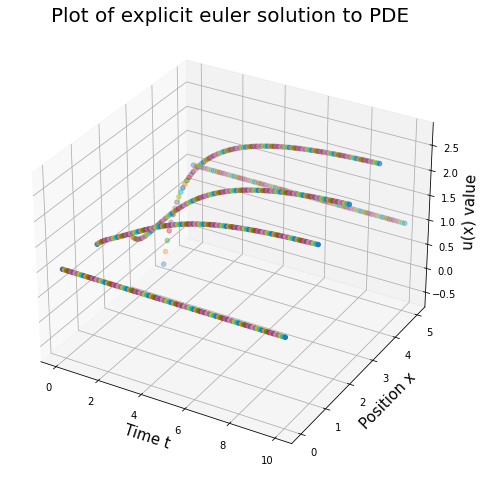

In [14]:
# Plotting
fig = plt.figure(figsize = (8,12))
ax = plt.axes(projection='3d')
for index, t in enumerate(store[:,0]):
    plotxvals = t*np.ones([len(xvals)])
    plotyvals = xvals
    plotzvals = store[index,1:]
    ax.scatter(plotxvals,plotyvals,plotzvals, zorder=10*index)
#ax.view_init(10,210)
plt.title("Plot of explicit euler solution to PDE",pad=-20 ,fontsize=20)
ax.set_xlabel("Time t",fontsize=15)
ax.set_ylabel("Position x",fontsize=15)
ax.set_zlabel("u(x) value",fontsize=15)
plt.show()


TODO: make script that does everything: initial value func, construct A,b, pass correct form to solve_to, then append with dirichlet constant values on the sides.
Next make 3d plotter. do a meshgrid tvals vs xvals to get x,y, then plot u_solution as z

Next, make function that does all this, outputs finished x,t store
Finally make an option in function to plot nice

In [9]:
# testing concatenation

foo = np.ones([5,4])
print(foo)
zoop = 2*np.ones([5,1])
print(zoop)
zen = np.concatenate((zoop,foo), axis=1)

[[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]
[[2.]
 [2.]
 [2.]
 [2.]
 [2.]]
